In [1]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
unmasker.tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [3]:
unmasker.model.bert.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [4]:
token_ids = unmasker.tokenizer.encode(
    "It's totally okay to write garbage - as long as you edit brilliantly. - C. J. Cherryh", 
    return_tensors="pt"
)
print(token_ids)

tensor([[  101,  2009,  1005,  1055,  6135,  3100,  2000,  4339, 13044,  1011,
          2004,  2146,  2004,  2017, 10086,  8235,  2135,  1012,  1011,  1039,
          1012,  1046,  1012,  9115,  2232,   102]])


In [5]:
token_embeddings = unmasker.model.bert.embeddings.word_embeddings(token_ids)
print("Shape:", token_embeddings.shape)
print("Embeddings:", token_embeddings)

Shape: torch.Size([1, 26, 768])
Embeddings: tensor([[[ 0.0136, -0.0265, -0.0235,  ...,  0.0087,  0.0071,  0.0151],
         [-0.0449, -0.0279, -0.0088,  ...,  0.0133,  0.0185,  0.0093],
         [-0.0358, -0.0052,  0.0095,  ...,  0.0151,  0.0150, -0.0561],
         ...,
         [-0.0020, -0.0589, -0.0479,  ..., -0.0058, -0.0947, -0.0618],
         [-0.0441,  0.0140, -0.0428,  ..., -0.0099, -0.0332,  0.0232],
         [-0.0145, -0.0100,  0.0060,  ..., -0.0250,  0.0046, -0.0015]]],
       grad_fn=<EmbeddingBackward0>)


In [6]:
actual_embedding_matrix = unmasker.model.bert.embeddings.word_embeddings.get_parameter("weight").detach()
print("Shape of embedding matrix:", actual_embedding_matrix.shape)
print("Matrix:", actual_embedding_matrix)

Shape of embedding matrix: torch.Size([30522, 768])
Matrix: tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]])


In [7]:
import torch
import torch.nn.functional as F

vocabulary_size = actual_embedding_matrix.shape[0]

one_hot_encoded_tokens = F.one_hot(token_ids, num_classes=vocabulary_size).squeeze()
print("One hot encoding shape:", one_hot_encoded_tokens.shape)
print("One hot encoding:", one_hot_encoded_tokens)

One hot encoding shape: torch.Size([26, 30522])
One hot encoding: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [8]:
torch.where(one_hot_encoded_tokens > 0)[-1]

tensor([  101,  2009,  1005,  1055,  6135,  3100,  2000,  4339, 13044,  1011,
         2004,  2146,  2004,  2017, 10086,  8235,  2135,  1012,  1011,  1039,
         1012,  1046,  1012,  9115,  2232,   102])

In [9]:
torch.all(token_embeddings.squeeze() == one_hot_encoded_tokens.type(torch.float32) @ actual_embedding_matrix)

tensor(True)

In [10]:
input_sentence = "A: I like this NLP seminar! B: What is the [MASK] about?"
unmasker(input_sentence)

[{'score': 0.7154601812362671,
  'token': 18014,
  'token_str': 'seminar',
  'sequence': 'a : i like this nlp seminar! b : what is the seminar about?'},
 {'score': 0.056508973240852356,
  'token': 8835,
  'token_str': 'lecture',
  'sequence': 'a : i like this nlp seminar! b : what is the lecture about?'},
 {'score': 0.02652328833937645,
  'token': 2831,
  'token_str': 'talk',
  'sequence': 'a : i like this nlp seminar! b : what is the talk about?'},
 {'score': 0.02160906419157982,
  'token': 3116,
  'token_str': 'meeting',
  'sequence': 'a : i like this nlp seminar! b : what is the meeting about?'},
 {'score': 0.016296016052365303,
  'token': 17899,
  'token_str': 'symposium',
  'sequence': 'a : i like this nlp seminar! b : what is the symposium about?'}]

In [15]:
from transformers import AutoModelForMaskedLM

model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased", output_attentions=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def get_tokens_and_token_ids(tokenizer, sentence):
    token_ids = tokenizer.encode(input_sentence, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(token_ids.squeeze())
    return tokens, token_ids

def get_attention_scores(model, token_ids):
    outputs = model(token_ids)
    return outputs.attentions
    
def plot_attention_heatmap(attention_scores, attention_layer_idx, attention_head_idx):
    assert 0 <= attention_layer_idx < len(attention_scores), "Attention layer index out of range"
    assert 0 <= attention_head_idx < len(attention_scores[attention_layer_idx][0]), "Attention head index out of range"

    # First index is the attention layer, the second one is the batch index, the third is the index of the attention head
    attention = attention_scores[attention_layer_idx][0, attention_head_idx].detach()
    attention_df = pd.DataFrame(attention, columns=tokens, index=tokens)

    sns.heatmap(attention_df)
    plt.show()

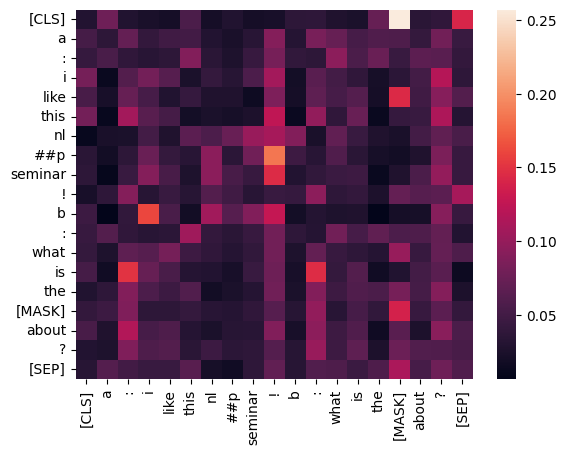

In [16]:
tokens, token_ids = get_tokens_and_token_ids(unmasker.tokenizer, input_sentence)
attention_scores = get_attention_scores(model, token_ids)
plot_attention_heatmap(attention_scores, 0, 0)

In [17]:
from bertviz import head_view

head_view(attention_scores, tokens)

<IPython.core.display.Javascript object>